# Antiderivative operator from an aligned dataset

# Problem setup

We will learn the antiderivative operator
$$
G: v \mapsto u
$$
defined by an ODE
$$
\frac{du(x)}{dx} = v(x), \qquad x \in [0, 1],
$$
with IC `u(0)=0`.

We learn `G` from a dataset. Each data point in the dataset is one pair of `(v, u)`, generated as follows:

1. A random function `v` is sampled from a Gaussian random field (GRF) with the resolution `m=100`.
2. Sovle `u` for `v` numerically. We assume that for each `u`, we have the values of `u(x)` in the same `N_u=100` locations. Because we have the values of `u(x)` in the same locations, we call this dataset as "alligned data".

# Implementation

To use DeepONet, we need to organize the dataset in the following format:

- Input of the branch net: the functions $v$.
- Input of the trunck net: the locations $x$ of $u(x)$ values.
- Output: the values of $u(x)$ in different locations for different $v$.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
d = np.load("deepxde/deeponet_antiderivative_aligned/antiderivative_aligned_train.npz", allow_pickle=True)
d

NpzFile 'deepxde/deeponet_antiderivative_aligned/antiderivative_aligned_train.npz' with keys: X, y

In [ ]:
d['X'][0].shape, d['X'][1].shape, d['y'].shape

((150, 100), (100, 1), (150, 100))

In [ ]:
X_train = (d['X'][0].astype(np.float32), d['X'][1].astype(np.float32))
y_train = d['y'].astype(np.float32)

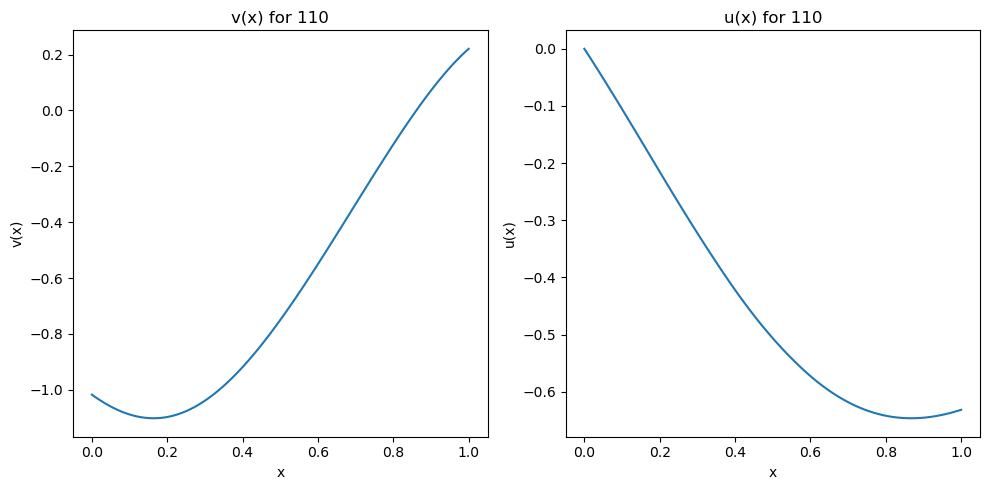

In [ ]:
idx = np.random.choice(150)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X_train[1], X_train[0][idx, :])
plt.xlabel('x')
plt.ylabel('v(x)')
plt.title(f'v(x) for {idx}')

plt.subplot(1, 2, 2)
plt.plot(X_train[1], y_train[idx, :])
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'u(x) for {idx}')

plt.tight_layout()
plt.show()

In [ ]:
d = np.load("deepxde/deeponet_antiderivative_aligned/antiderivative_aligned_test.npz", allow_pickle=True)
d

NpzFile 'deepxde/deeponet_antiderivative_aligned/antiderivative_aligned_test.npz' with keys: X, y

In [ ]:
d['X'][0].shape, d['X'][1].shape, d['y'].shape

((1000, 100), (100, 1), (1000, 100))

In [ ]:
X_test = (d['X'][0].astype(np.float32), d['X'][1].astype(np.float32))
y_test = d['y'].astype(np.float32)

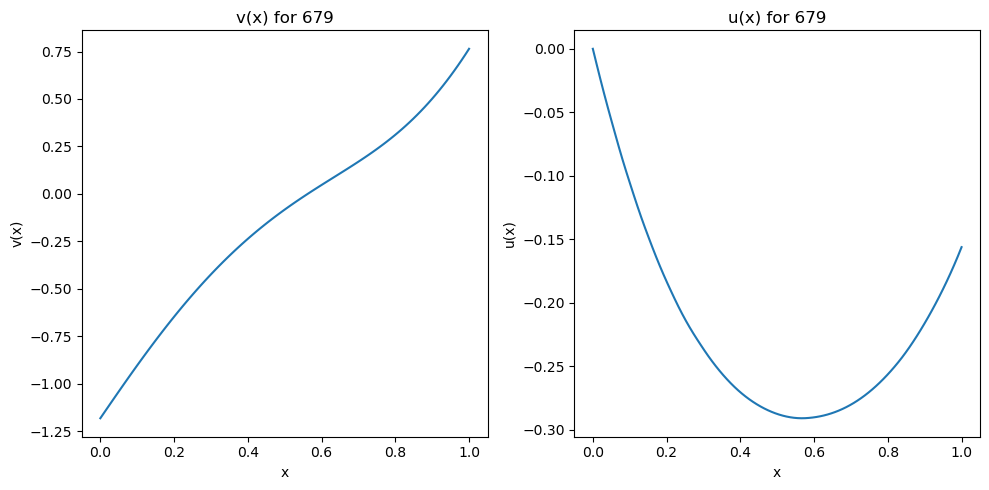

In [ ]:
idx = np.random.choice(1000)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[1], X_test[0][idx, :])
plt.xlabel('x')
plt.ylabel('v(x)')
plt.title(f'v(x) for {idx}')

plt.subplot(1, 2, 2)
plt.plot(X_test[1], y_test[idx, :])
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title(f'u(x) for {idx}')

plt.tight_layout()
plt.show()

In [ ]:
dde.data.TripleCartesianProd?

Init signature: dde.data.TripleCartesianProd(X_train, y_train, X_test, y_test)
Docstring:     
Dataset with each data point as a triple. The ordered pair of the first two
elements are created from a Cartesian product of the first two lists. If we compute
the Cartesian product of the first two arrays, then we have a ``Triple`` dataset.

This dataset can be used with the network ``DeepONetCartesianProd`` for operator
learning.

Args:
    X_train: A tuple of two NumPy arrays. The first element has the shape (`N1`,
        `dim1`), and the second element has the shape (`N2`, `dim2`).
    y_train: A NumPy array of shape (`N1`, `N2`).
File:           ~/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/deepxde/data/triple.py
Type:           ABCMeta
Subclasses:     

In [ ]:
data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

In [ ]:
dde.nn.DeepONetCartesianProd?

Init signature:
dde.nn.DeepONetCartesianProd(
    layer_sizes_branch,
    layer_sizes_trunk,
    activation,
    kernel_initializer,
    regularization=None,
)
Docstring:     
Deep operator network for dataset in the format of Cartesian product.

Args:
    layer_sizes_branch: A list of integers as the width of a fully connected network,
        or `(dim, f)` where `dim` is the input dimension and `f` is a network
        function. The width of the last layer in the branch and trunk net should be
        equal.
    layer_sizes_trunk (list): A list of integers as the width of a fully connected
        network.
    activation: If `activation` is a ``string``, then the same activation is used in
        both trunk and branch nets. If `activation` is a ``dict``, then the trunk
        net uses the activation `activation["trunk"]`, and the branch net uses
        `activation["branch"]`.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:       

In [ ]:
m = 100
dim_x = 1
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot uniform"
)

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])

Compiling model...
'compile' took 0.324371 s



In [ ]:
loss_history, train_state = model.train(iterations=10000)

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.58e-01]    [3.03e-01]    [1.06e+00]    
1000      [5.50e-05]    [7.69e-05]    [3.52e-02]    
2000      [2.63e-05]    [4.57e-05]    [2.71e-02]    
3000      [1.83e-05]    [3.31e-05]    [2.38e-02]    
4000      [2.21e-05]    [3.41e-05]    [2.29e-02]    
5000      [1.42e-05]    [2.47e-05]    [2.06e-02]    
6000      [1.26e-05]    [2.25e-05]    [1.97e-02]    
7000      [1.13e-05]    [2.06e-05]    [1.89e-02]    
8000      [9.69e-06]    [1.87e-05]    [1.81e-02]    
9000      [8.43e-06]    [1.72e-05]    [1.74e-02]    
10000     [6.06e-06]    [1.47e-05]    [1.65e-02]    

Best model at step 10000:
  train loss: 6.06e-06
  test loss: 1.47e-05
  test metric: [1.65e-02]

'train' took 37.648619 s



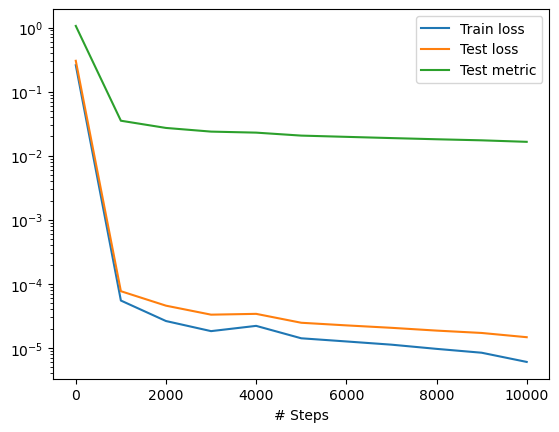

In [ ]:
dde.utils.plot_loss_history(loss_history)

## Evaluation

If $v(x) = \cos(\pi x)$, 

then $u(x) = \frac{1}{\pi} \sin(\pi x)$ with IC $u(x=0)=0$

In [ ]:
xt = np.linspace(0, 1, 100)
vt = np.cos(np.pi*xt)
ut = (1/np.pi)*np.sin(np.pi*xt)

In [ ]:
# v(x)                          x                u(x)
# (num_functions, num_points), (num_points, 1), (num_functions, num_points)
X_test[0].shape, X_test[1].shape, y_test.shape

((1000, 100), (100, 1), (1000, 100))

In [ ]:
vt.shape, xt.shape, ut.shape

((100,), (100,), (100,))

In [ ]:
vt = vt[None, :]
xt = xt[:, None]
ut = ut[None, :]

In [ ]:
vt.shape, xt.shape, ut.shape

((1, 100), (100, 1), (1, 100))

In [ ]:
Xt = (vt, xt)

In [ ]:
ut_pred = model.predict(Xt)
ut_pred.shape

(1, 100)

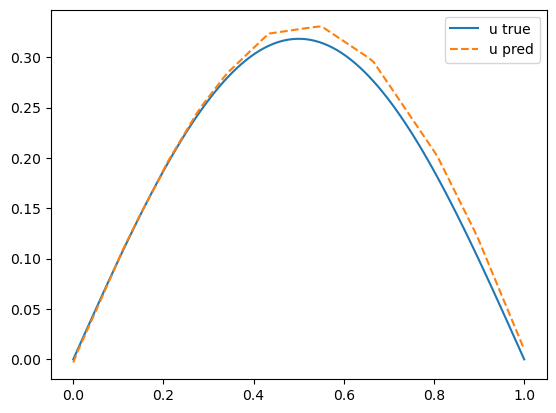

In [ ]:
plt.figure()
plt.plot(Xt[1][:, 0], ut[0, :], '-', label='u true')
plt.plot(Xt[1][:, 0], ut_pred[0, :], '--', label='u pred')
plt.legend()
plt.show()